#### ASTR 3890 - Selected Topics: Data Science for Large Astronomical Surveys (Spring 2022)
***N. Hernitschek***
___

# Final Exam
### Due: Monday, May 2nd at 4.00pm CST


---

## Problem 1

A model with 10 parameters describes the statistics of the temperature fluctuations
of the Cosmic Microwave Background. We fit this model to 45 published data points of the
variance of the fluctuations as a function of angular scale and find χ2 = 52.7. We then set 5
of the model parameters to zero and fit the model again, this time getting χ2 = 54. Were we
justified in using all 10 parameters in the model?


### Solution

No, 10 parameters is likely overfitting. While the goal is the minimize the χ2, and 52.7 is less than 54, the difference is not very large, only a 2.5% increase, despite taking out have of the parameters. Often the more simple solution is the better one in order to avoid overfitting. Overfitting is when you are making a model that only matches your data super well but does not generalize to new data and is not actually telling you anything about the underlying distribution and what it is likely to be.

## Problem 2

Explain what Malmquist bias is. Use the Malmquist bias to explain how it can fool the unwary astronomer into thinking that stellar or galaxy luminosities measured at different wavelengths can appear correlated, even if there is no true correlation.

### Solution

The Malmquist bias can be summarized by the fact that astronomical surveys can only see objects bright enough to be detected, and thus, underextimate the number of low magnitude/luminousity objects. However, just because you can't see them doesn't mean they aren't there.

This could fool the unwary astronomer because they could measure stellar or galaxy luminosities at different wavelengths and find that they both have a similar distribution that is lacking in weight at slower luminosities. However, this is just because both wavelengths suffer from the Malmquist bias and are going to have less weight at low luminosity because they can't be detected. When this bias is accounted for, the distributions in this region could be completely different and thus be indictive of the lack of correlation.

## Problem 3

1) Read in final_data_3.npy. This is a (10 x 2) numpy array, with voltage measurements in the first column and heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on the sample mean for this data.

2) Fit the appropriate ln-likelihood function and find the best-fit mean voltage.

3) Compute and plot the Bayesian posterior probability density (not the log posterior) for the mean voltage assuming a uniform prior for the mean in the range 3 to 7. Make sure this posterior pdf is normalized.

4) By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to the sample mean plus/minus the standard error, respectively. Also find the MAP value of the mean.

### Solution

In [4]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

[[4.36 2.24]
 [4.   1.94]
 [4.87 1.39]
 [5.64 2.55]
 [6.14 1.69]
 [5.92 1.38]
 [3.93 1.  ]
 [6.58 1.6 ]
 [3.78 1.  ]
 [5.84 1.  ]]


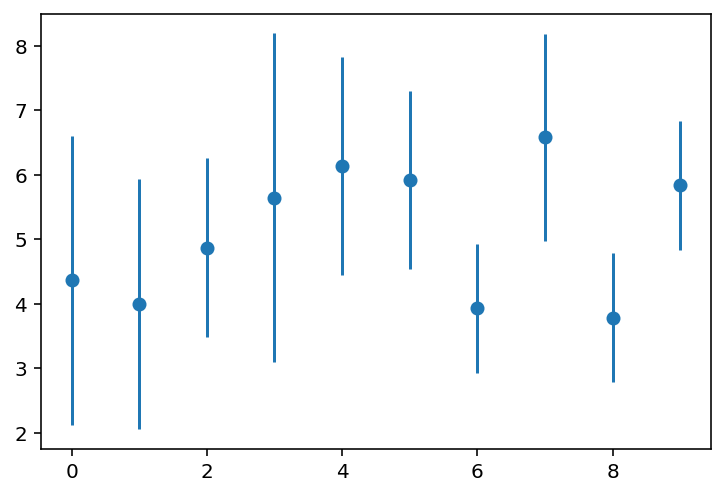

In [118]:
data_1 = np.load("final_data_3.npy")
print(data_1)

plt.errorbar(np.arange(10), data_1[:,0], yerr=data_1[:,1], fmt='o')
plt.show()

In [98]:
print("sample mean: " + str(np.average(data_1[:,0])))
st_error = np.std(data_1[:,0])/np.sqrt(len(data_1[:,0])) #standard deviation / sqrt(n)
print("standard error on sample mean: " + str(st_error))

sample mean: 5.106
standard error on sample mean: 0.31152913186410025


$$F_{est} = \frac{\sum w_i F_i}{\sum w_i }    $$ with $w_i=1/e_i^2$

Maximizes

$$
\log L = \frac{1}{2}\sum_{i=1}^N \left[ \log(2 \pi e_i^2)+\frac{(F_i-F_{true})^2}{e_i^2}   \right]
$$

In [99]:
error = data_1[:,1]
w_i = 1/(error**2)
F_est = np.sum(w_i*data_1[:,0])/np.sum(w_i)
print(F_est)

4.942118214425304


In [151]:
def log_prior(theta):
    # needs to be between 3 and 7
    if theta <= 3 or theta >= 7:
        return -np.inf
    else:
        return 1
    
def log_likelihood(theta, F, e):
    return -0.5 * np.sum(np.log(2 * np.pi * e ** 2)
                         + (F - theta) ** 2 / e ** 2)

def log_posterior(theta, F, e):
    return log_prior(theta) + log_likelihood(theta, F, e)



In [152]:
t = np.linspace(3,7)
post = np.zeros_like(t)
for i in range(t.size):
    post[i] = np.exp(log_posterior(t[i], data_1[:,0], data_1[:,1]))

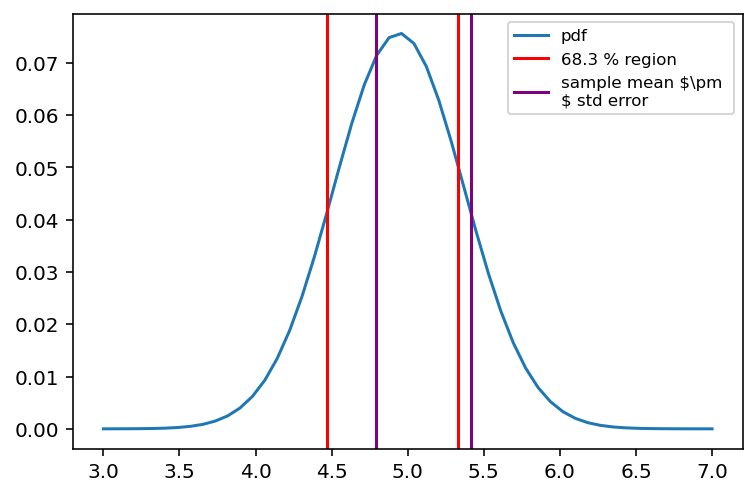

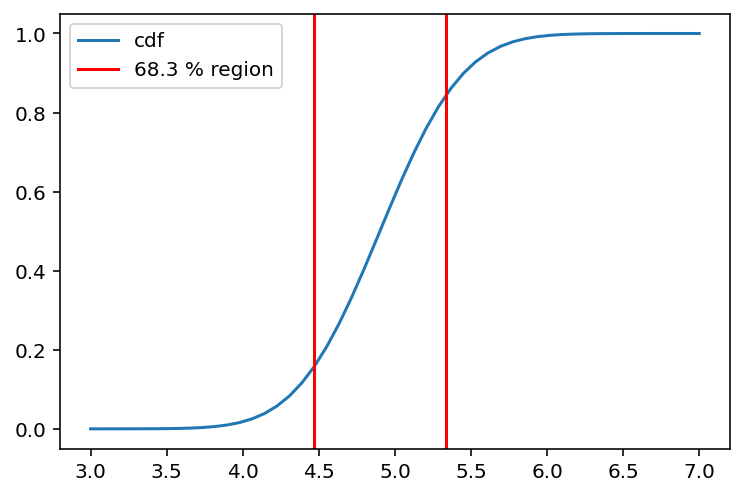

In [169]:
from scipy.interpolate import interp1d

interp = interp1d(np.cumsum(post)/np.sum(post), t, bounds_error=True)

plt.plot(t, post/np.sum(post), label='pdf')
plt.axvline(interp(.1585), color='red', label='68.3 % region')
plt.axvline(interp(.8415), color='red')
plt.axvline(np.average(data_1[:,0])+st_error, color='purple', label='sample mean $\pm \n$ std error')
plt.axvline(np.average(data_1[:,0])-st_error, color='purple')
plt.legend(fontsize='small')
plt.show()

plt.plot(t, np.cumsum(post)/np.sum(post), label='cdf')
plt.axvline(interp(.1585), color='red', label='68.3 % region')
plt.axvline(interp(.8415), color='red')

plt.legend()
plt.show()

In [171]:
#Does MAP mean MAX?
print("Max of the posterior: " + str(t[np.argmax(post/np.sum(post))]))

Max of the posterior: 4.959183673469388


## Problem 4

This problem has to do with dimensional reduction. We're going to load in a sample of SDSS Imaging data.

1. Execute the cell below to read in the data, print out the feature names, and create a data matrix out of a subset of features.


2. Use PCA (with randomized svd_solver for speed if necessary) to reduce the data matrix down to features. What is the explained variance of the data encapsulated in these eigen-features?

3. 
    Access the `type` key of the `data` structure and make an array of labels out of these. Do some research in astroML documentation to find out what these integer types correspond to, and state that here.

4. Choose 5000 random integers between 0 and the number of samples in the data matrix. Record these integers because you'll use them later. Make a scatter plot of the PCA-reduced data for these 5000 random samples, colored by their corresponding type. (You may want to set the transparency to be lower than 1 to see the mixing of samples.)


5.  Now try some non-linear dimensional reduction. These algorithms are slower than PCA, so you will operate only on the 5000 random samples identified in the previous part.

* Try LocallyLinearEmbedding, Isomap, and TSNE algorithms, setting the number of components to be 2 in all cases.
* As in the PCA case, make scatter plots of the dimensionally-reduced data, color coded by their type. For LLE and Isomap, experiment with the number of nearest neighbors between 5 and 100 to see what visually gives the best separation in type populations. For TSNE, do the same for the perplexity attribute.
* Which algorithm gives the cleanest way to visually see the two populations of sources? (This will be subjective according to the samples you trained on, and even the randomness of the algorithms.)




### Solution

In [78]:
from astroML.datasets import fetch_imaging_sample
data = fetch_imaging_sample()  
print(data.shape)  # number of objects in dataset

print(data.dtype.names)

keylist = ['ra', 'dec', 'rExtSFD', 'uRaw', 
           'gRaw', 'rRaw', 'iRaw', 'zRaw', 
           'uErr', 'gErr', 'rErr', 'iErr', 
           'zErr', 'uRawPSF', 'gRawPSF', 
           'rRawPSF', 'iRawPSF', 'zRawPSF', 
           'upsfErr', 'gpsfErr', 'rpsfErr', 
           'ipsfErr', 'zpsfErr']

X = np.column_stack([data[key] for key in keylist]) 

(330753,)
('ra', 'dec', 'run', 'rExtSFD', 'uRaw', 'gRaw', 'rRaw', 'iRaw', 'zRaw', 'uErr', 'gErr', 'rErr', 'iErr', 'zErr', 'uRawPSF', 'gRawPSF', 'rRawPSF', 'iRawPSF', 'zRawPSF', 'upsfErr', 'gpsfErr', 'rpsfErr', 'ipsfErr', 'zpsfErr', 'type', 'ISOLATED')


In [79]:
#Example call from 7.3.2
import numpy as np
from sklearn.decomposition import PCA


pca = PCA(2) # n_components can be optionally set
pca.fit(X) 

eigenvalues = pca.transform(X) # compute the subspace projection of X, 4 eigenvalues for each of the 100 samples
mean = pca.mean_ # length 23 mean of the data
eigenvectors = pca.components_ # 4x10 matrix of components, multiply each by respective eigenvalue to reconstruct

# Reconstruction of object1
# Xreconstruct[0] = mean + eigenvectors*eigenvalues[0]

print(eigenvalues.shape)
print(eigenvectors.shape)

evals = pca.explained_variance_ratio_ 
print('Expained fractional variance of data encapsulated in the eigenvalues: ')
print(str(evals))

(330753, 2)
(2, 23)
Expained fractional variance of data encapsulated in the eigenvalues: 
[0.53320897 0.25010565]


In [80]:
comp = pca.transform(X)
print(comp.shape)

(330753, 2)


In [81]:
labels = data['type']

This tells if source is detectable or not. 

In [82]:
np.random.seed()
nrows = 5000
ind = np.random.randint(X.shape[0], size=nrows)

In [83]:
def plot(data, labels):
    plt.scatter(data[:,0][labels==3], data[:,1][labels==3], alpha=0.1, color='red')
    plt.scatter(data[:,0][labels==6], data[:,1][labels==6], alpha=0.1, color='blue')
    plt.show()

PCA


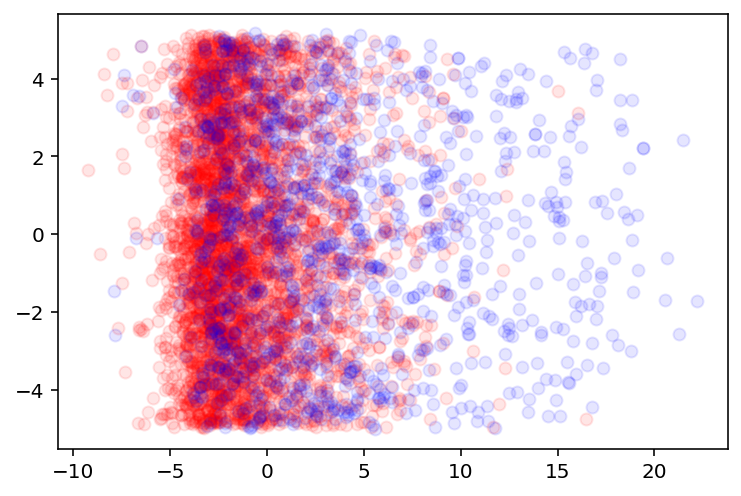

In [84]:
print("PCA")
plot(comp[ind], labels[ind])

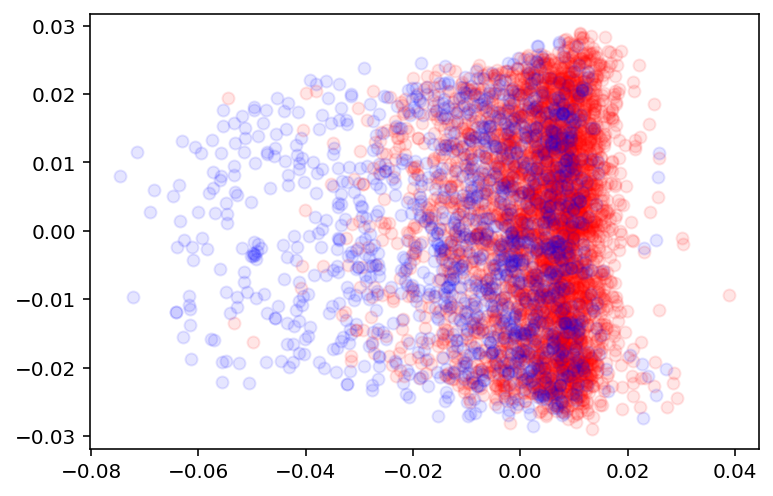

In [85]:
from sklearn.manifold import LocallyLinearEmbedding

embedding = LocallyLinearEmbedding(n_neighbors = 70, n_components=2)
X_e_trans = embedding.fit_transform(X[ind])
plot(X_e_trans, labels[ind])

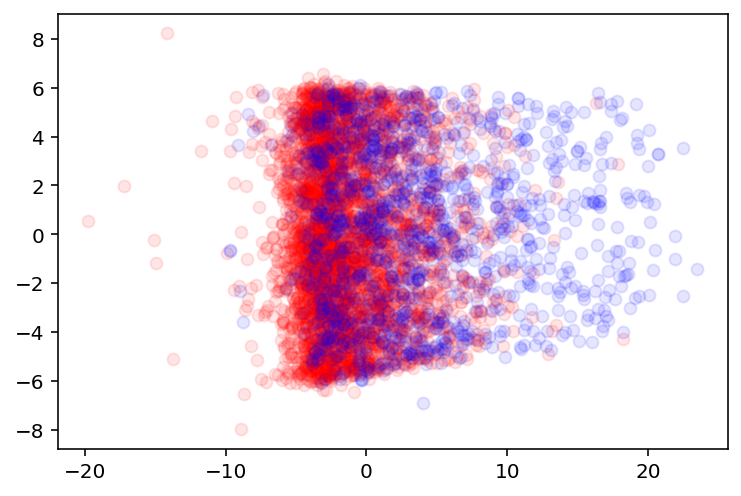

In [88]:
from sklearn.manifold import Isomap

isomap = Isomap(n_neighbors = 70, n_components=2)
X_i_trans = isomap.fit_transform(X[ind])
plot(X_i_trans, labels[ind])

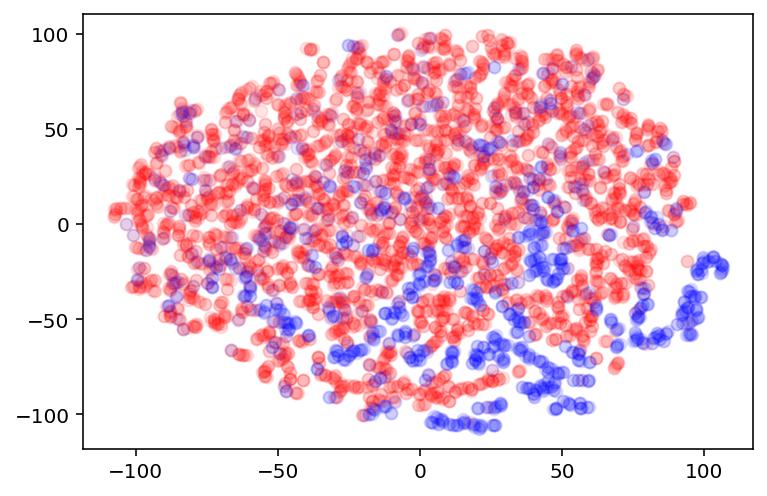

In [90]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity = 5, n_components=2)
X_t_trans = tsne.fit_transform(X[ind])
plot(X_t_trans, labels[ind])